# 5.2 インストラクションチューニング

## 5.2.1 インストラクションチューニングの基礎

In [1]:
data = [{ "from": "human", "value": "冷たいシャワーを毎日浴びることの長所と短所について、短いパラグラフを書いてください。" }, { "from": "gpt", "value": "冷たいシャワーを毎日浴びることのメリットは、注意力を高め、気分を高揚させること、健康全般を改善すること、ガスや電気を使ってお湯を沸かさないので光熱費の節約になることです。一方、冷たいシャワーはあまり歓迎されるものではありません。特に寒い冬には、冷たいシャワーに浸かるという精神的な障壁を超えられず、失敗や失望を考えてしまうかもしれません。" }]

prompt_template_example = "{from}: {value}"
instruction_text = ""
for d in data[:-1]:
    instruction_text += prompt_template_example.format(**d)
response_text = prompt_template_example.format(**data[-1])

print("指示部分:")
print(instruction_text)
print("\n応答部分:")
print(response_text)

指示部分:
human: 冷たいシャワーを毎日浴びることの長所と短所について、短いパラグラフを書いてください。

応答部分:
gpt: 冷たいシャワーを毎日浴びることのメリットは、注意力を高め、気分を高揚させること、健康全般を改善すること、ガスや電気を使ってお湯を沸かさないので光熱費の節約になることです。一方、冷たいシャワーはあまり歓迎されるものではありません。特に寒い冬には、冷たいシャワーに浸かるという精神的な障壁を超えられず、失敗や失望を考えてしまうかもしれません。


## 5.2.2 インストラクションチューニングの実装

In [2]:
from datasets import load_dataset

ds = load_dataset("databricks/databricks-dolly-15k")
print(ds["train"]) 
# Dataset({
#     features: ['instruction', 'context', 'response', 'category'],
#     num_rows: 15011
# })

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 15011
})


In [3]:
ds_train = ds["train"].filter(lambda x: x["context"] == "")
print(f"コンテキスト空のデータ: {ds_train.num_rows}") # 10544

コンテキスト空のデータ: 10544


In [4]:
prompt_template = """\
### Question: {instruction}
### Answer: {response}{eos_token}"""

def format_input(example):
    """バッチ処理用のフォーマット関数"""
    texts = []
    for instruction, response in zip(example['instruction'], example['response']):
        text = prompt_template.format(
            instruction=instruction,
            response=response,
            eos_token=tokenizer.eos_token
        )
        texts.append(text)
    return texts

sample = ds_train[0]
print("サンプルデータ:")
print(f"  instruction: {sample['instruction'][:50]}...")
print(f"  response: {sample['response'][:50]}...")

#  サンプルデータ:
#  instruction: Which is a species of fish? Tope or Rope...
#  response: Tope...

サンプルデータ:
  instruction: Which is a species of fish? Tope or Rope...
  response: Tope...


In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto" if torch.cuda.is_available() else "cpu",
)

print(f"パラメータ数: {sum(p.numel() for p in model.parameters()):,}") # パラメータ数: 124,439,808

パラメータ数: 124,439,808


Token indices sequence length is longer than the specified maximum sequence length for this model (1040 > 1024). Running this sequence through the model will result in indexing errors


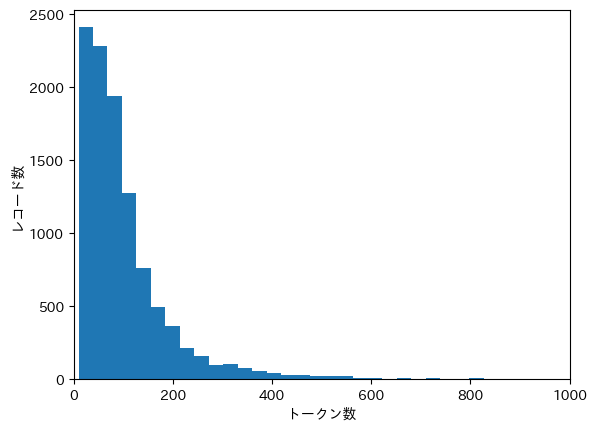

In [6]:
import matplotlib.pyplot as plt
import japanize_matplotlib

fig, ax = plt.subplots()

lengths = [len(tokenizer.encode(text)) for text in format_input(ds_train)]
ax.hist(lengths, bins=200)
ax.set_xlim(0, 1000)
ax.set_xlabel("トークン数")
ax.set_ylabel("レコード数")
fig.savefig("histogram.png", dpi=300, bbox_inches="tight")

In [7]:
max_length = 512

def token_length_filter(x):
    text = prompt_template.format(
        instruction=x["instruction"],
        response=x["response"],
        eos_token=tokenizer.eos_token
    )
    return len(tokenizer.encode(text)) <= max_length

ds_train = ds_train.filter(token_length_filter)
print(f"トークン数フィルタ後: {ds_train.num_rows}") # トークン数フィルタ後: 10400

トークン数フィルタ後: 10400


In [8]:
prompt_template_infer = """\
### Question: {instruction}
### Answer: """
response_template = "### Answer:"

@torch.inference_mode()
def inference(model, tokenizer, user_input):
    prompt = prompt_template_infer.format(instruction=user_input)
    device = next(model.parameters()).device
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    output = model.generate(
        input_ids,
        max_new_tokens=128,
        do_sample=False,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.eos_token_id
    )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=False)
    response_start = generated_text.find(response_template) + len(response_template)
    response_end = generated_text.find(tokenizer.eos_token, response_start)
    if response_end == -1:
        response_end = len(generated_text)
    response = generated_text[response_start:response_end].strip()
    return response

In [9]:
test_questions = [
    "What is the capital of Japan?"
]

print("チューニング前の応答:")
print("="*80)
before_responses = {}
for question in test_questions:
    response = inference(model, tokenizer, question)
    before_responses[question] = response
    print(f"Q: {question}")
    print(f"A: {response}")
    print("-"*80)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


チューニング前の応答:
Q: What is the capital of Japan?
A: The Japanese government has a long history of using money to finance its own military. The first major example was in 1848 when it used $1,000 for an army unit and then spent about half that on other expenses such as uniforms and food supplies (see below). In fact, during World War II , this amount had been raised by more than 100% from what would have been needed if there were no war at all . This led to many people believing they could use their savings or even buy some goods with cash instead of having them go into debt because "the Government will not pay you back." However, since most countries do
--------------------------------------------------------------------------------


In [10]:
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

config = SFTConfig(
    output_dir='./output',
    save_strategy="no",
    save_total_limit=1,
    logging_steps=100,
    max_seq_length=max_length,
    num_train_epochs=3,
    gradient_accumulation_steps=1,
    per_device_train_batch_size=8,
    lr_scheduler_type="constant",
)

trainer = SFTTrainer(
    model,
    args=config,
    train_dataset=ds_train,
    formatting_func=format_input,
    data_collator=collator,
)

/data1/book-llm-from-scratch/.venv/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:413: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


In [11]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.025100
200,2.942800
300,2.889400
400,2.906400
500,2.868900
600,2.854700
700,2.864500
800,2.939000
900,2.857300
1000,2.917600


TrainOutput(global_step=3900, training_loss=2.6450819436097754, metrics={'train_runtime': 324.948, 'train_samples_per_second': 96.015, 'train_steps_per_second': 12.002, 'total_flos': 3779723971584000.0, 'train_loss': 2.6450819436097754, 'epoch': 3.0})

In [12]:
print("="*80)
print("インストラクションチューニングの効果")
print("="*80)

for i, question in enumerate(test_questions, 1):
    print(f"\n質問 {i}: {question}")
    print(f"\n【チューニング前】")
    print(before_responses[question])
    print(f"\n【チューニング後】")
    after_response = inference(model, tokenizer, question)
    print(after_response)
    print("="*80)

インストラクションチューニングの効果

質問 1: What is the capital of Japan?

【チューニング前】
The Japanese government has a long history of using money to finance its own military. The first major example was in 1848 when it used $1,000 for an army unit and then spent about half that on other expenses such as uniforms and food supplies (see below). In fact, during World War II , this amount had been raised by more than 100% from what would have been needed if there were no war at all . This led to many people believing they could use their savings or even buy some goods with cash instead of having them go into debt because "the Government will not pay you back." However, since most countries do

【チューニング後】
Tokyo, Japan.  The capital in Japan is Tokyo and it's capital is Tokyo.  It was founded by Emperor Shigeru I in the year 1450 and is still maintained today as one major city in Asia with over 2 million residents.  It has a population of around 7 million people which is more than any other country in Europe or N